In [73]:
%%html
<style>
table { margin-left: 0 !important; }
</style>

# ML Project (CSE 464) (Facial Recognition)

- Under the mentorship of **Dr. Pratik Chattopadhyay**

####  <ins>Details of the students</ins>

| Name           | Roll Number | Department           |
|:----------------|:-------------|:----------------------|
| Arjun Salyan   | 17045026    | Chemical Engineering |
| Pranav Gupta   | 17045067    | Chemical Engineering |
| Sparsh Kataria | 17045109    | Chemical Engineering |
| Satyam Saxena  | 17045120    | Chemical Engineering |


We have made a model that recognises faces! We have also explored Dimensionality Reduction with PCA.

In this project, other than the inbuild Python libraries, we also used third party library libraries `numpy`, `matplotlib`, `sklearn`, and `skimage`.

### Loading the dataset

All the data is first loaded as a numpy array.

In [14]:
import os

# third party libraries
from skimage import io
import numpy as np

X = []
y = []

# loop over all the directories in the dataset folder
for inner_dir in os.listdir('dataset'):
    if not os.path.isdir(os.path.join('dataset', inner_dir)):
        continue

    label = int(inner_dir[1:])
    
    # for every directory, get the files inside it
    for file in os.listdir(os.path.join('dataset', inner_dir)):
        file_name = os.path.join('dataset', inner_dir, file)
               
        image = io.imread(fname=file_name)

        X.append(image)
        y.append(label)

# convert Python lists to numpy arrays
X = np.array(X, dtype='float64')
y = np.array(y)

# let's see the structure of the arrays populated with the datesets
print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))

X.shape: (400, 112, 92), y.shape: (400,)


### Understanding the output

It is clear from the shape of the arrays that we have 400 images with dimenstions 112*92

### Let's view a sample

Now that we know our data and have it stored as a numpy array, we can view it to get a better understanding of the scenario.

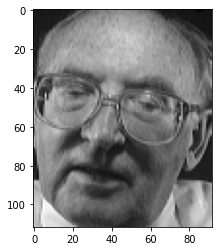

In [12]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(X[0],cmap="gray")
plt.show()

### There are 40 subjects in our dataset with 10 images for each of them.

In [13]:
print('Number of images :', X.shape[0])
print('Shape of each image:', X.shape[1], 'x', X.shape[2])

Number of images : 400
Shape of each image: 112 x 92


### How is the data stored?
`X` is a 3D NumPy array. For each of the 400 images, we have a corresponding 2D matrix storing the pixel values.

### Extraction of Features
We will flatten this 2D matrix that contains the pixel values and use this as the feature vector for the image.

In [16]:
# reshape `X` into 400xN, where N is the number of features (112x92).

X=np.reshape(X,(400,112*92))
X.shape

(400, 10304)

The number of features obtained this way are very large. We will have to perform dimensionality reduction, which we do in later stages.

### Data Standardisation

Let us standardise the data. We will be only using the data corresponding to the first `num_labels` classes.

In [32]:
num_of_labels = 5
X_s = X[y <= num_labels]
y_s = y[y <= num_labels]

In [33]:
from sklearn.preprocessing import scale

X_s_scaled = scale(X_s)

### Dimentionality Reduction

We will now use the dimensionality reduction algorithm called the PCA algorithm. We will reduce the dimensionality of the data to 2 and plot it.

In [34]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca.fit(X_s_scaled)
X_s_2d=pca.transform(X_s_scaled)

X_s_2d.shape

(50, 2)

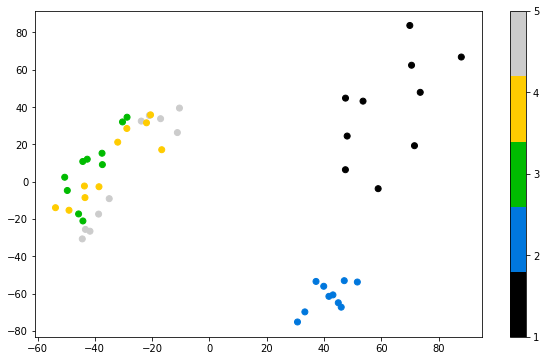

In [67]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(X_s_2d[:,0], X_s_2d[:,1], c=y_s, cmap=plt.cm.get_cmap('nipy_spectral', num_labels)) 

cb = plt.colorbar()
loc = np.arange(1, num_labels+1)
cb.set_ticks(loc)

We can clearly see PCA has projected the highly dimensional dataset into 2 dimensions, which we can see on plotting look clustered. 

### Splitting the dataset

We will now split our datasets into training and testing datsets

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Standardising using scikit-learn

Standardising the dataset is not only helpful for training machine learning models but is also a requirement before applying PCA. We will standardise all three `X_train`, `X_val` and `X_test`. 

In [42]:
from sklearn.preprocessing import scale, StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

#### Training after Dimensionality reduction

Dimensionality reduction using PCA speeds up the process of training without much loss in accuracy.

In [43]:
pca=PCA(n_components=0.99)

In [45]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print("New dimensionality:", pca.n_components_)

New dimensionality: 237


### Model: Logistic Regression

We first train using the the logistic regression model. This is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1 and the sum adding to one.

In [64]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=.01,  solver = 'liblinear',multi_class = 'auto')
clf = clf.fit(X_train_pca, y_train)

### Model: Linear SVC

The objective of a Linear SVC (Support Vector Classifier) is to fit to the data we provide, returning a "best fit" hyperplane that divides, or categorizes, your data.

In [65]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=.001)
clf = clf.fit(X_train_pca, y_train)

### Testing 

We now need to perform the final step, which is, testing our two models using the test data we obtained earlier.

In [52]:
def plot_gallery(images, titles, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        fig = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()
        
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        yield 'predicted: {0}\ntrue: {1}'.format(y_pred[i], y_test[i])

In [53]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [58]:
from sklearn.metrics import accuracy_score

clf = LogisticRegression(C=.01,  solver = 'liblinear',multi_class = 'auto')
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print('Accuracy for logistic regression : {:.6f}'.format(accuracy_score(y_test, y_pred)))

Accuracy for logistic regression : 0.866667


In [59]:
clf = LinearSVC(C=.001)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print('Accuracy score for Linear SVC: {:.6f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score for Linear SVC: 0.866667


### Can our model Predict?

We can view the predictions that our model is making.

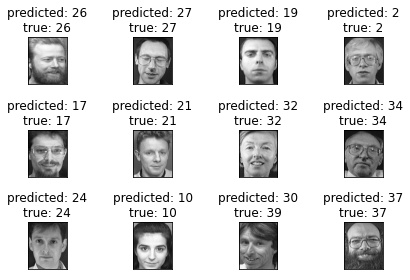

In [61]:
prediction_titles = list(titles(y_pred, y_test))
plot_gallery(X_test.reshape(-1, 112, 92), prediction_titles)